## Example C - Lotka-Volterra

**(works only with Swyft 0.4.4; to be updated soon)**

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 27 April 2023

Let's now use a toy model for the dynamic of a biological system in which two species interact, one as predator and the other as prey. This is usually described by the Lotka–Volterra equations, also known as the predator–prey equations, a pair of first-order nonlinear differential equations.

In [ ]:
import numpy as np
import swyft
import pylab as plt
import scipy
import torch
from scipy import stats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In order to make our simulator quicker in solving the differential equations, we will use [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). 

In [ ]:
!pip install diffrax
import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Dopri5, DiscreteTerminatingEvent
import jax
import jax.numpy as jnp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 13.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [ ]:
_lv_solver = Dopri5()

@jax.jit
def lv_deriv(t, Y, args):
    alpha, beta, gamma, delta = args
    dY = jnp.array([alpha * Y[0] - beta * Y[0] * Y[1], delta * Y[0] * Y[1] - gamma * Y[1]])
    return dY

@jax.jit
def lv_solver_dense(Y0, tspan, params, rtol=1e-7, atol=1e-7):
    term = ODETerm(lv_deriv)
    solver = _lv_solver
    saveat = SaveAt(t0=False, t1=True, ts=None, dense=True)
    stepsize_controller = PIDController(rtol=rtol, atol=atol)
    solution = diffeqsolve(terms=term,
                           solver=solver,
                           t0=tspan[0], t1=tspan[1],
                           y0=Y0, 
                           dt0=None,
                           args=params,
                           saveat=saveat,
                           stepsize_controller=stepsize_controller,
                           discrete_terminating_event=None)
    Y_fun = jax.jit(jax.vmap(solution.evaluate, (0)))
    ts = jnp.linspace(tspan[0], tspan[1], 100)
    return Y_fun(ts)
lv_solver_dense_vmap = jax.jit(jax.vmap(lv_solver_dense, (0, None, 0)))

Here is our simulator. This model is adapted from [arxiv:2209.11057](https://arxiv.org/abs/2209.11057).

In [ ]:
class Simulator(swyft.Simulator):
    def __init__(self, Y0 = np.array([2, 4]), tmax = 50, bounds=None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.bounds=bounds

        # Initial conditions
        self.Y0 = Y0 # initial number of preys and predators

        # Timesteps
        self.tmax = tmax # maximum time
      
    def get_params(self):
        """ 
        Get Lotka-Volterra parameters:
        - alpha: intrinsic preys reproduction rate
        - beta: preys mortality rate due to predators encountered
        - gamma: predator reproduction rate according to preys encountered and eaten
        - delta: intrinsic predator mortality rate
        """
        return swyft.RectBoundSampler(stats.uniform(np.array([0., 0., 0., 0.]), np.array([1.5, 1., 1., 1.])), bounds = self.bounds)()
          
    def get_evolution(self, z):
        """
        Solves Lotka-Volterra ODEs for one prey and one predator species and 
        returns the number of preys X and predators Y at given timestep.
        """
        Ytrue = np.asarray(lv_solver_dense(Y0=jnp.array(self.Y0), 
                               tspan=jnp.array([0., self.tmax]), 
                               params=jnp.array(z)).T).copy()
        Ytrue[np.where(Ytrue<=0)] = 1e-20
        return Ytrue

    def get_demographic_noise(self, Ytrue, R=0.3):
        """
        Add demographic noise with zero mean and variance proportional to 
        the true underlying population.
        """
        YDnoise = Ytrue + np.sqrt(R*Ytrue) * np.random.randn(*Ytrue.shape)
        return YDnoise

    def build(self, graph):
        z = graph.node('z', self.get_params)
        Ytrue = graph.node('Ytrue', self.get_evolution, z)
        YDnoise = graph.node('YDnoise', self.get_demographic_noise, Ytrue)

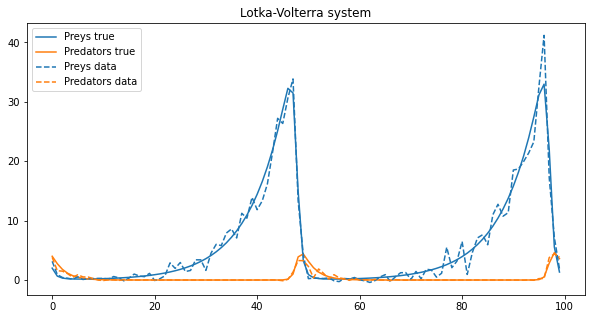

In [ ]:
sim = Simulator()
obs = sim.sample()

# Plot
plt.figure(figsize=(10,5))
plt.plot(obs['Ytrue'][0], label="Preys true")
plt.plot(obs['Ytrue'][1], label="Predators true")
plt.plot(obs['YDnoise'][0], c='tab:blue', ls='--', label="Preys data")
plt.plot(obs['YDnoise'][1], c='tab:orange', ls='--', label="Predators data")
plt.legend(loc="best")
plt.title("Lotka-Volterra system") 
plt.show()

Now we define a simple network to perform the data compression and generate the logratios. This can certainly be improved though!

In [ ]:
class Network(swyft.SwyftModule):
    def __init__(self, lr = 1e-3, gamma = 1.):
        super().__init__()
        self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = lr),
              torch.optim.lr_scheduler.ExponentialLR, dict(gamma = gamma))
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 10, num_params = 4, varnames = 'z', dropout = 0.0)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(100, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(64, 10),
            torch.nn.ReLU()
        )

    def forward(self, A, B):
        f = self.net(A['YDnoise'])
        logratios = self.logratios(f, B['z'])
        return logratios

In [ ]:
def round(obs, bounds = None):
    sim = Simulator(bounds = bounds)
    samples = sim.sample(10000)
    dm = swyft.SwyftDataModule(samples, fractions = [0.7, 0.2, 0.1], num_workers = 3, batch_size = 64, on_after_load_sample=sim.get_resampler(targets = ["YDnoise"]))
    lr_monitor = LearningRateMonitor(logging_interval='step')
    early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=5, verbose=False, mode='min')
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='./logs/', filename='lv_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 20, callbacks=[lr_monitor, early_stopping_callback])
    network = Network()
    trainer.fit(network, dm)
    checkpoint_callback.to_yaml("./logs/lv.yaml")
    ckpt_path = swyft.best_from_yaml("./logs/lv.yaml")
    trainer.test(network, dm, ckpt_path = ckpt_path)
    prior_samples = sim.sample(N = 10000, targets = ['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (4,), threshold = 1e-5)
    return predictions, new_bounds, samples

In [ ]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(3):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.9 K
1 | net       | Sequential             | 63.5 K
-----------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -1.8827433586120605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 48it [00:00, ?it/s]

New bounds: tensor([[3.5697e-05, 1.4996e+00],
        [8.8303e-05, 9.9993e-01],
        [1.1083e-01, 9.9984e-01],
        [2.9122e-05, 7.8809e-01]])


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.9 K
1 | net       | Sequential             | 63.5 K
-----------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -1.8446929454803467
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 110it [00:00, ?it/s]

New bounds: tensor([[4.9141e-05, 1.4995e+00],
        [4.3906e-04, 9.9991e-01],
        [1.1613e-01, 9.9969e-01],
        [2.0347e-04, 7.8798e-01]])


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 71.9 K
1 | net       | Sequential             | 63.5 K
-----------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -2.200033664703369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 110it [00:00, ?it/s]

New bounds: tensor([[4.3150e-04, 6.6515e-01],
        [1.4022e-01, 9.9968e-01],
        [2.0927e-01, 9.9965e-01],
        [2.3018e-04, 5.4193e-01]])


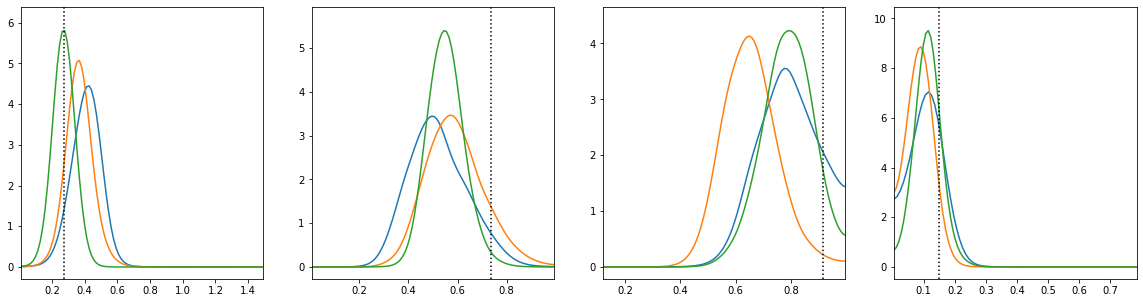

In [ ]:
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(4)], obs['z'])}
colors = ['tab:blue', 'tab:orange', 'tab:green']
fig, axes = plt.subplots(1, 4, figsize = (20, 5))
for i in range(4):
    swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(4)], fig=fig, truth=truth, smooth = 3, bins = 100, contours = False, color=colors[i])